自制实现的GRU训练结果:
epoch: 100, 对'time traveller'的预测:time travellere the the the the the the the the the the the the 
epoch: 200, 对'time traveller'的预测:time traveller the the the the the the the the the the the the t
epoch: 300, 对'time traveller'的预测:time traveller they thing the time traveller that they the line 
epoch: 400, 对'time traveller'的预测:time traveller filby back andfilby s anecdote collapsedthe thing
epoch: 500, 对'time traveller'的预测:time traveller but now you begin to seethe object of my investig
困惑度1.07, 68166.8词元/秒 在cuda:0上
对prefix为'time traveller'的预测:time traveller but now you begin to seethe object of my investig
对prefix为'traveller'的预测:traveller care which has only two dimensions we can represe


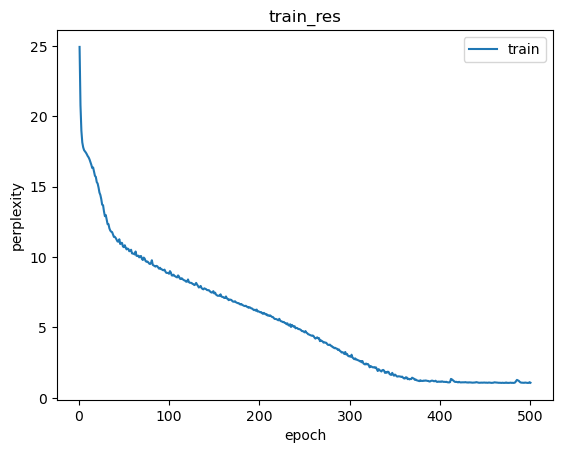

PytorchAPI实现的GRU训练结果:
epoch: 100, 对'time traveller'的预测:time travellere the the the the the the the the the the the the 
epoch: 200, 对'time traveller'的预测:time traveller that is a mover the time traveller that is a mavi
epoch: 300, 对'time traveller'的预测:time traveller which alo gemane pranes there wasnthough sime tla
epoch: 400, 对'time traveller'的预测:time traveller with a slight accession ofcheerfulness really thi
epoch: 500, 对'time traveller'的预测:time travelleryou can show black is white by argument said filby
困惑度1.03, 566558.6词元/秒 在cuda:0上
对prefix为'time traveller'的预测:time travelleryou can show black is white by argument said filby
对prefix为'traveller'的预测:travelleryou can show black is white by argument said filby


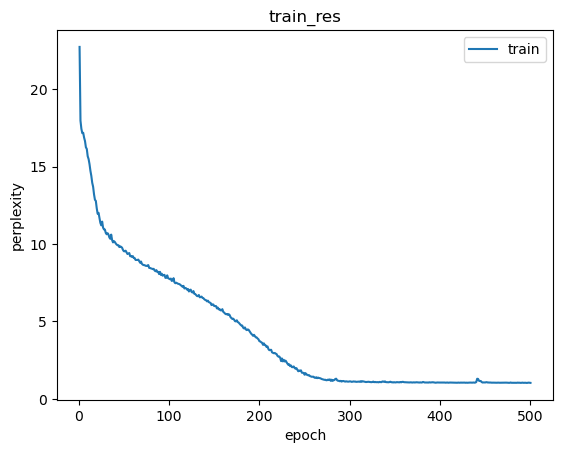

In [1]:
import torch, utils
from torch import nn
"""
门控循环单元的作用:
1.门控循环神经网络可以更好地捕获时间步距离很长的序列上的依赖关系。
2.重置门有助于捕获序列中的短期依赖关系。
3.更新门有助于捕获序列中的长期依赖关系。
4.重置门打开时，门控循环单元包含基本循环神经网络；更新门打开时，门控循环单元可以跳过子序列。
"""

# 从零实现
def init_params_gru(vocab_size, num_hiddens, device):
    """
    参数:\n
        vocab_size : 词表大小\n
        num_hiddens : 隐藏层单元数量\n
        device : 设备\n
    返回:GRU的参数列表
    """
    def normal(shape):
        """从标准正态分布提取数据*0.01初始化权重"""
        return torch.randn(size=shape, device=device) * 0.01

    def three():
        """返回一个三元组(输入->门的权重参数, 隐藏->门的权重参数, 门的偏置参数)"""
        return (normal((num_inputs, num_hiddens)),
                normal((num_hiddens, num_hiddens)),
                torch.zeros(num_hiddens, device=device))
    
    num_inputs = num_outputs = vocab_size
    W_xz, W_hz, b_z = three() # 更新门的参数
    W_xr, W_hr, b_r = three() # 重置门参数
    W_hx, W_hh, b_h = three() # 候选隐状态参数
    W_hq, b_q = normal((num_hiddens, num_outputs)), torch.zeros(num_outputs, device=device) # 输出层参数
    params = [W_xz, W_hz, b_z, W_xr, W_hr, b_r,W_hx, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

def init_state_gru(batch_size, num_hiddens, device):
    """初始化隐状态的函数,返回一个全零形状为(batch_size, num_hiddens)的张量"""
    return (torch.zeros(size=(batch_size, num_hiddens), device=device), )

def gru_forward(inputs, state, params):
    """
    GRU的前向传播函数\n
    参数:\n
        inputs : 批量矩阵X转置后的独热编码,形状为(时间步数量, 批量大小, 词表大小), 每一行是批量矩阵中各个样本在某一时间步的特征\n
        state : 上一时间步的隐状态，张量变量，形状为(批量大小,隐藏单元数)\n
        params : GRU参数列表\n
    返回:\n
        形状为(num_steps*batch_size, num_outputs)的预测序列 和 (输出层的隐藏状态, )的元组
    """
    W_xz, W_hz, b_z, W_xr, W_hr, b_r,W_hx, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    for X in inputs: # 迭代时间步
        Z = torch.sigmoid(X@W_xz + H@W_hz + b_z) # 更新更新门
        R = torch.sigmoid(X@W_xr + H@W_hr + b_r) # 更新重置门
        H_tilde = torch.tanh(X@W_hx + (R*H)@W_hh +b_h) # 更新候选隐状态
        H = Z*H + (1-Z)*H_tilde
        Y = H@W_hq + b_q
        outputs.append(Y)
    return torch.concat(outputs, dim=0), (H, )

batch_size, num_steps = 32, 35
train_iter, vocab = utils.load_time_machine_data(batch_size, num_steps)
vocab_size, num_hiddens, device = len(vocab), 256, utils.try_gpu()
num_epochs, lr = 500, 1
net = utils.RNNScratch(vocab_size, num_hiddens, init_params_gru, gru_forward, init_state_gru, device)

print("自制实现的GRU训练结果:")
utils.rnn_train(net, train_iter, vocab, lr, num_epochs, device)

# PytorchAPI简介实现
num_inputs = vocab_size
net = utils.RNN(nn.GRU(input_size=num_inputs, hidden_size=num_hiddens), vocab_size).to(device)

print("PytorchAPI实现的GRU训练结果:")
utils.rnn_train(net, train_iter, vocab, lr, num_epochs, device)

#### 一、更新各个门的公式
重置门$R_t$和更新门$Z_t$<br>
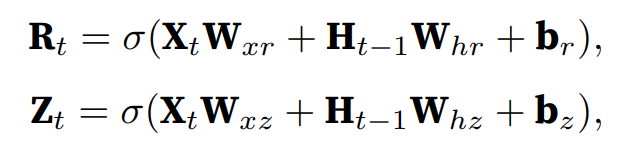
#### 二、得到时间步t的候选隐状态的公式
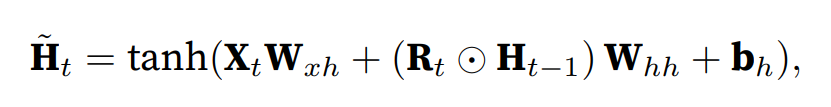<br>
$R_t$和$H_{t−1}$ 的元素相乘可以减少以往状态的影响。<br>
每当重置门$R_t$中的项接近1时，就恢复为一个普通的循环神经网络。<br>
对于重置门$R_t$中所有接近0的项，候选隐状态是以$X_t$作为输入的多层感知机的结果。<br>
因此，任何预先存在的隐状态都会被重置为默认值。
#### 三、结合更新门确定新的隐状态的公式
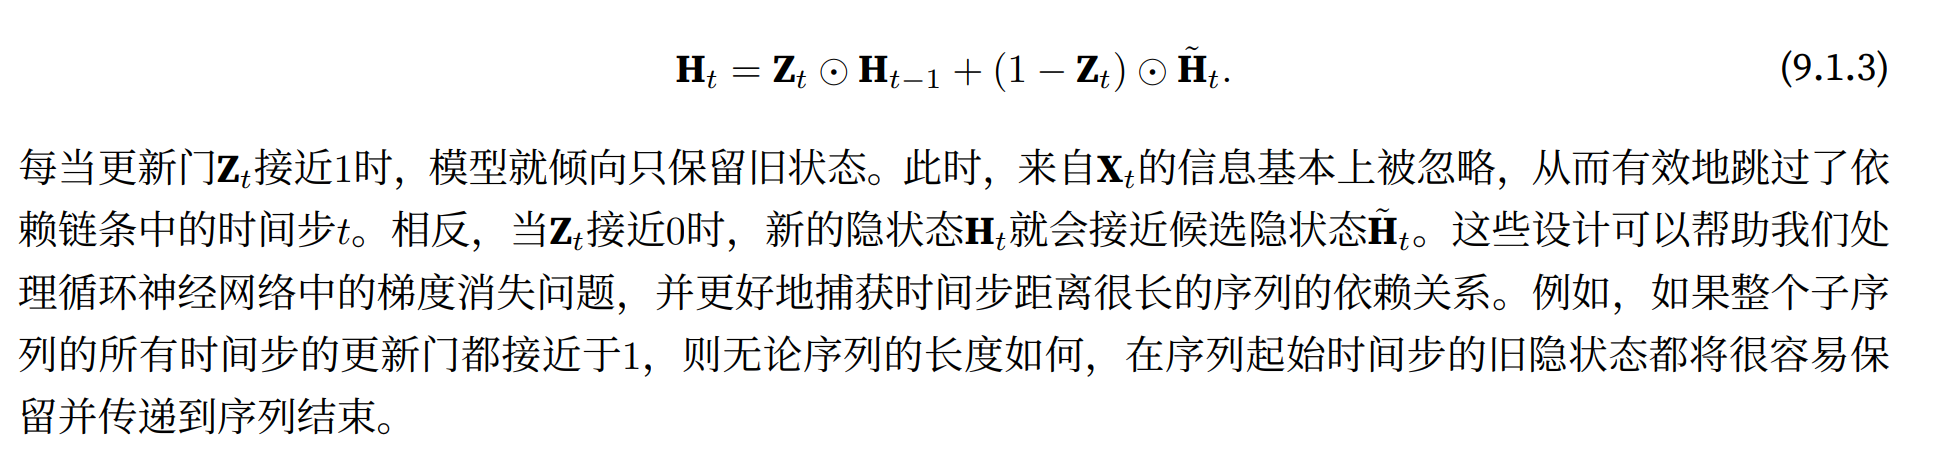
#### 四、GRU模型的隐状态更新图
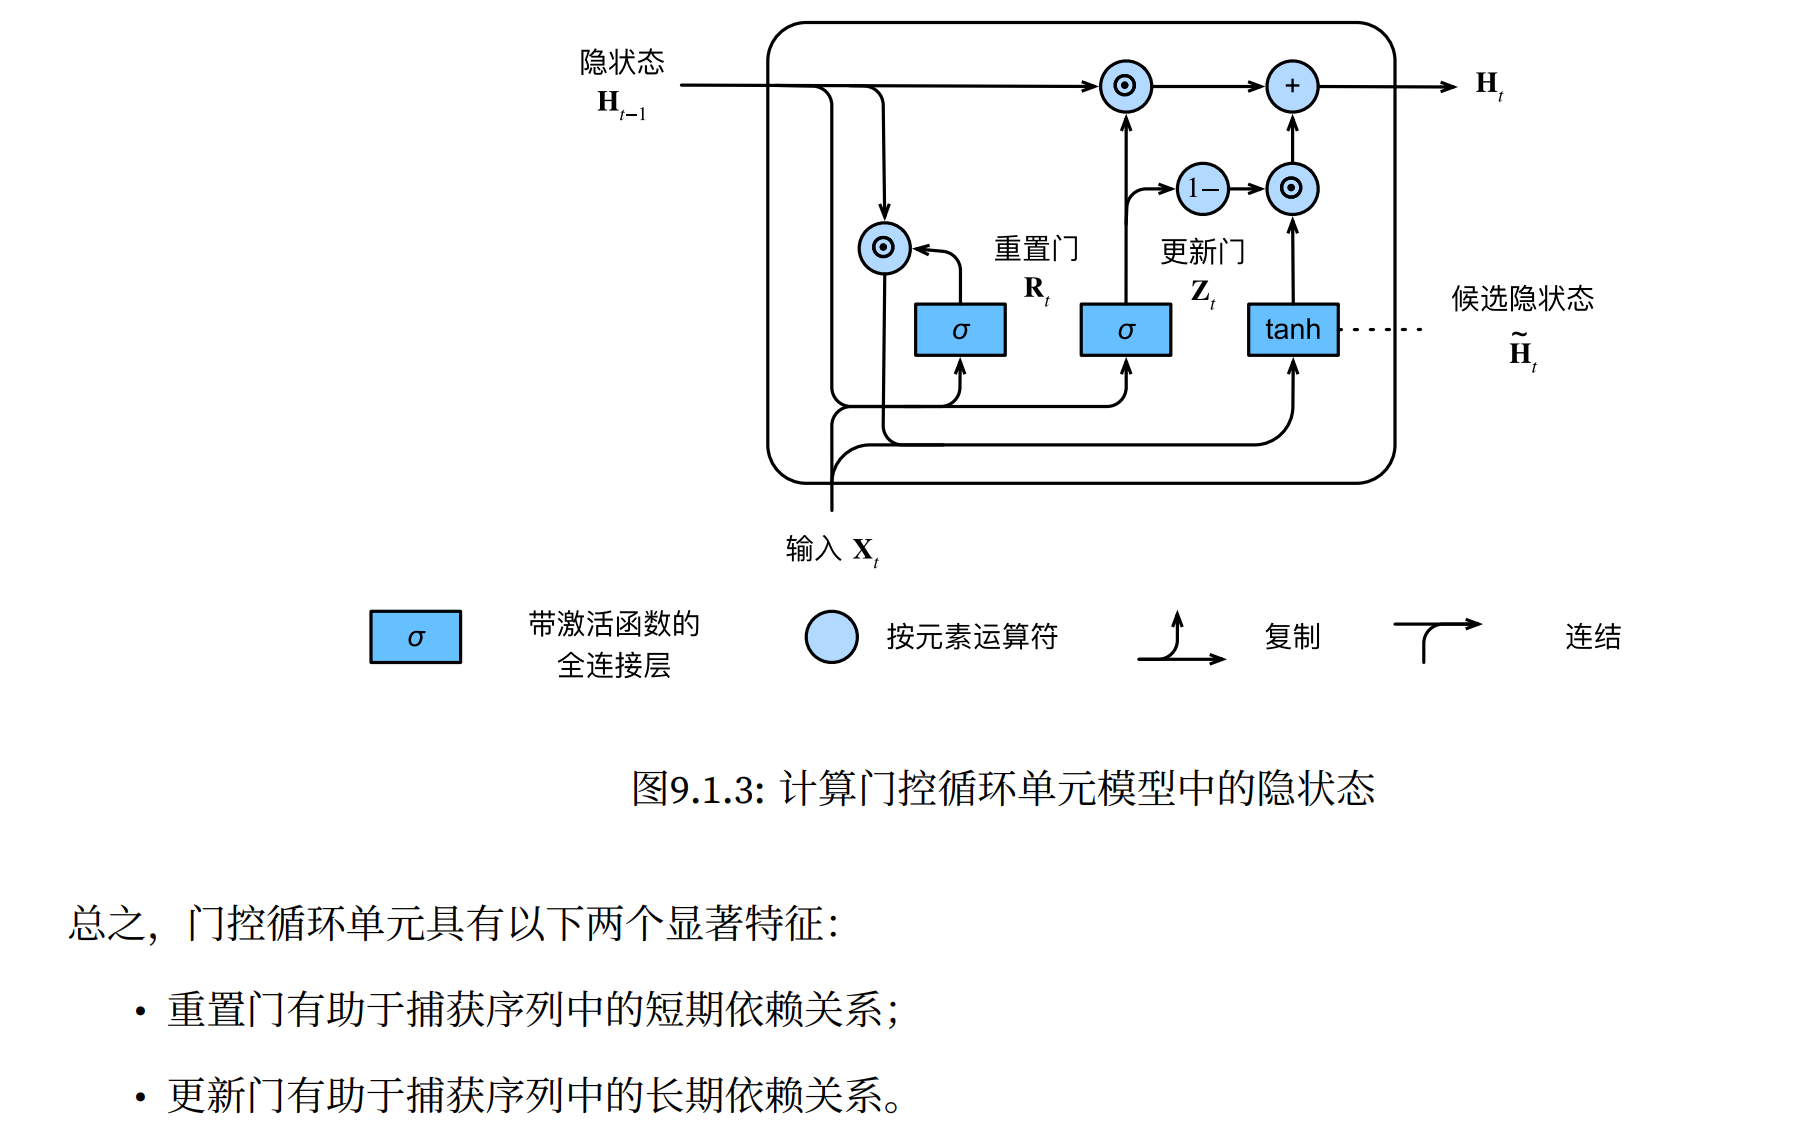